# Evaluate 

In [1]:
import sys
print(sys.executable, sys.version)


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import trimesh

from os.path import join, abspath
from IPython.display import display, HTML
from glob import glob

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

%matplotlib inline

# for local import 
sys.path.append(abspath('..'))

from main.config import Config
from main.model import Model
from main.dataset import Dataset
from main.smpl import Smpl

from vis_util import draw_2d_on_image, show_2d_pose, show_3d_pose

/home/mmc-user/.virtualenvs/hmr2-notebook/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [2]:
eval_date = '30042020-164015'

class EvalConfig(Config):
    BATCH_SIZE = 64
    ENCODER_ONLY = True
    LOG_DIR = join('/', 'data', 'ssd1', 'russales', 'logs', eval_date)
    DATA_DIR = join('/', 'data', 'ssd1', 'russales', 'new_records')
    DATASETS = ['mpii_3d', 'h36m']
    # RESTORE_PATH = join(LOG_DIR, 'ckpt-6')

# class Config is implemented as singleton, inizialize subclass first!
config = EvalConfig()

In [3]:
# inizialize model 
model = Model()

Saving logs to /data/ssd1/russales/logs/30042020-164015

Configurations:
BATCH_SIZE                     64
DATASETS                       ['mpii_3d', 'h36m']
DATA_DIR                       /data/ssd1/russales/new_records
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_ONLY                   True
EPOCHS                         55
GENERATOR_2D_LOSS_WEIGHT       60.0
GENERATOR_3D_LOSS_WEIGHT       60.0
GENERATOR_LEARNING_RATE        1e-05
GENERATOR_WEIGHT_DECAY         0.001
ITERATIONS                     3
JOINT_TYPE                     cocoplus
LOG_DIR                        /data/ssd1/russales/logs/30042020-164015
NUM_CAMERA_PARAMS              3
NUM_JOINTS                     23
NUM_JOINTS_GLOBAL              24
NUM_KP2D                       19
NUM_KP3D                       14
NUM_PARALLEL                   16
NUM_POSE_PARAMS                72
NUM_SHAPE_PARAMS           

### run evaluation

In [4]:
result = model.test()

initialize test dataset...
Done (t=0.31873011589050293)

Start of Testing



Time taken for testing 66.311270236969 sec



### sort results by sequence 

In [5]:
all_kp3d_mpjpe = result['kp3d_mpjpe'].numpy()
all_kp3d_mpjpe_aligned = result['kp3d_mpjpe_aligned'].numpy()
sequences = result['seq'].numpy()

### evaluate per sequence 

In [6]:
eval_dict = {}
indices = range(len(sequences))
for i, sequence in zip(indices, sequences):
    sequence = sequence.decode("utf-8")
    mpjpe_tuple = tuple([all_kp3d_mpjpe[i], all_kp3d_mpjpe_aligned[i]])
    if sequence not in eval_dict:
        eval_dict[sequence] = [mpjpe_tuple]
    else:
        eval_dict[sequence].append(mpjpe_tuple)

In [7]:
names, data = eval_dict.keys(), np.ndarray(shape=(len(eval_dict), 9), dtype=np.float32)

indices = range(len(names))
for i, value in zip(indices, eval_dict.values()):
    values_per_seq = np.asarray(value, dtype=np.float32)
    mpjpe = values_per_seq[:, 0, :]
    mpjpe_aligned = values_per_seq[:, 1, :]
    
    mean_mpjpe_aligned = np.mean(mpjpe_aligned)
    mean_mpjpe = np.mean(mpjpe)
    
    data[i, 0] = mean_mpjpe_aligned  # mean_error_aligned
    data[i, 1] = mean_mpjpe  # mean_error
    data[i, 2] = np.median(mpjpe)  # median_error
    data[i, 3] = np.std(mpjpe)  # standard deviation
    data[i, 4] = mpjpe.min()  # min
    data[i, 5] = mpjpe.max()  # max
    data[i, 6] = np.percentile(mpjpe, 25)  # 25 percentile
    data[i, 7] = np.percentile(mpjpe, 50)  # 50 percentile
    data[i, 8] = np.percentile(mpjpe, 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_seq = pd.DataFrame(data, index=names, columns=columns)

df_seq = df_seq.sort_values(df_seq.columns[0]) # sort by ascending mean aligned

display(HTML(df_seq.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
h36m_sub9_Posing_cam58860488,92.633080,248.541412,209.659302,164.413345,9.235791,1104.147705,130.720001,209.659302,324.332825
h36m_sub9_Posing_cam60457274,95.282753,203.918808,167.347748,154.997833,5.737350,1098.687744,101.241867,167.347748,256.690491
h36m_sub9_Posing 1_cam60457274,98.770218,191.286575,157.185211,140.021469,2.530944,1007.447449,100.767105,157.185211,245.257263
h36m_sub9_Posing_cam55011271,99.162643,225.726486,180.261047,168.266937,2.417774,1143.966553,101.974106,180.261047,300.942230
h36m_sub11_Directions 1_cam60457274,101.214287,187.428406,144.414413,144.865616,5.796273,983.104004,94.253128,144.414413,242.878510
h36m_sub11_Directions_cam60457274,101.542160,180.769318,141.227844,141.644989,8.726998,937.110291,92.434021,141.227844,222.233826
h36m_sub9_Posing 1_cam58860488,101.910164,290.172211,237.204788,196.172440,11.762146,1286.153442,147.228073,237.204788,383.379456
h36m_sub11_Posing_cam60457274,102.871864,187.609055,150.715515,142.278305,13.651546,925.631226,98.858566,150.715515,232.200348
h36m_sub9_Directions_cam55011271,104.922432,185.967758,148.010895,155.261459,3.954004,1106.399048,81.946198,148.010895,235.467834
h36m_sub11_Posing 1_cam60457274,106.013062,183.267670,151.995239,136.417587,12.099034,858.223572,94.304672,151.995239,228.174866


In [8]:
df_seq.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,136.323959,287.272064,229.384552,205.789886,11.278487,1215.071655,135.486481,229.384552,390.326447
std,22.745144,62.677818,52.700634,38.913971,8.677824,184.353821,32.466568,52.700634,97.733757
min,92.633080,165.638901,120.833168,128.041397,1.493760,794.567566,75.258217,120.833168,195.073975
25%,121.943491,243.713539,196.722515,178.760406,5.743889,1102.895264,113.232277,196.722515,323.059158
50%,130.677399,275.099258,217.371613,201.914536,8.501300,1202.706543,129.512497,217.371613,373.668701
75%,146.367371,319.331863,252.731960,228.229282,13.022973,1295.674744,160.226002,252.731960,436.643150
max,218.908478,521.903381,455.082031,345.575897,44.712292,1846.229004,237.419373,455.082031,763.174927


### evaluate per joint

In [9]:
lsp_joints = ['ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 
             'ankle_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
             'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain']

data = np.ndarray(shape=(14, 9), dtype=float)
for i, _ in enumerate(lsp_joints):
    data[i, 0] = np.mean(all_kp3d_mpjpe_aligned[:, i])  # mean_error_aligned
    data[i, 1] = np.mean(all_kp3d_mpjpe[:, i])  # mean_error
    data[i, 2] = np.median(all_kp3d_mpjpe[:, i])  # median_error
    data[i, 3] = np.std(all_kp3d_mpjpe[:, i])  # standard deviation
    data[i, 4] = all_kp3d_mpjpe[:, i].min()  # min
    data[i, 5] = all_kp3d_mpjpe[:, i].max()  # max
    data[i, 6] = np.percentile(all_kp3d_mpjpe[:, i], 25)  # 25 percentile
    data[i, 7] = np.percentile(all_kp3d_mpjpe[:, i], 50)  # 50 percentile
    data[i, 8] = np.percentile(all_kp3d_mpjpe[:, i], 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_joint = pd.DataFrame(data, index=lsp_joints, columns=columns)
df_joint = df_joint.sort_values(df_joint.columns[0])

display(HTML(df_joint.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
neck,71.750092,147.532578,131.030045,99.713905,2.417774,976.156860,83.592400,131.030045,183.235359
shoulder_r,80.417198,172.817429,153.266098,102.196159,1.493760,911.368896,108.109606,153.266098,214.269421
shoulder_l,82.860901,238.596558,223.230560,129.789459,1.989133,988.408875,134.953793,223.230560,332.488792
hip_r,88.143997,125.090706,112.848137,77.250053,1.950205,281.847870,56.291230,112.848137,196.116619
hip_l,100.157913,125.090714,112.848206,77.250053,1.950166,281.847717,56.291229,112.848206,196.116322
elbow_r,103.597397,344.188812,309.814545,199.736252,5.763504,1220.365479,171.647770,309.814545,506.665024
elbow_l,104.336494,357.871521,309.048035,218.959106,4.015516,1322.772949,173.155560,309.048019,531.632492
knee_r,118.147682,307.946198,296.790466,164.970535,2.458121,1010.025940,184.496693,296.790451,402.566902
brain,120.542496,213.397964,189.310730,137.316177,4.988230,1418.360840,131.485535,189.310722,254.662109
knee_l,140.379852,225.444290,194.718781,141.185211,9.946839,1004.558838,132.444885,194.718773,274.383682


In [10]:
df_joint.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,133.962613,282.387165,255.079001,164.892916,4.182813,1161.944739,157.139028,255.078998,382.454885
std,61.965751,125.360774,117.744789,64.741463,2.739325,487.445897,74.090965,117.744790,174.008741
min,71.750092,125.090706,112.848137,77.250053,1.493760,281.847717,56.291229,112.848137,183.235359
25%,91.147476,182.962563,162.277256,109.094484,1.959937,979.219864,113.953588,162.277254,224.367593
50%,111.242088,272.366211,238.324081,153.077873,3.236818,1115.195709,149.677248,238.324085,362.439434
75%,163.795483,354.450844,309.622917,215.863911,5.569685,1541.600433,181.661409,309.622913,525.390625
max,267.791748,509.940186,483.528961,261.294556,9.946839,1846.229004,298.202705,483.528961,699.747650


### evaluate overall

In [11]:
all_mpjpe_aligned = np.mean(all_kp3d_mpjpe_aligned)
all_mpjpe = np.mean(all_kp3d_mpjpe)

print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(all_mpjpe_aligned, all_mpjpe))

Mean Aligned: 133.963 --- Mean: 282.387


In [12]:
percentiles = [10, 30, 50, 70, 90]
data = np.ndarray(shape=(5, 2), dtype=float)
for i, percentile in enumerate(percentiles):
    data[i, 0] = np.percentile(all_kp3d_mpjpe_aligned, percentile)
    data[i, 1] = np.percentile(all_kp3d_mpjpe, percentile)

columns = ['10%', '30%', '50%', '70%', '90%']
df_percentiles = pd.DataFrame(data.T, index=['Mean Aligned', 'Mean'], columns=columns)
df_percentiles

,10%,30%,50%,70%,90%
Mean Aligned,42.850340,74.43389,107.155487,153.831868,266.149490
Mean,73.595933,147.75074,220.542175,333.855936,592.803485


In [13]:
def eval_per_dataset(name):
    len_ds = len([k for k in eval_dict.keys() if name in k])
    data = []

    indices = range(len(eval_dict.keys()))
    for i, (key, value) in zip(indices, eval_dict.items()):
        if name not in key:
            continue

        values_per_seq = np.asarray(value, dtype=np.float32)
        mpjpe = values_per_seq[:, 0, :]
        mpjpe_aligned = values_per_seq[:, 1, :]

        mean_mpjpe_aligned = np.mean(mpjpe_aligned)
        mean_mpjpe = np.mean(mpjpe)
        
        data.append(tuple([mean_mpjpe_aligned, mean_mpjpe]))  
        
    data = np.asarray(data, dtype=float)
    return np.mean(data[:, 0]), np.mean(data[:, 1])

In [14]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('mpi')
print('MPII 3D')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

MPII 3D
Mean Aligned: 173.874 --- Mean: 361.516


In [15]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('h36m')
print('HUMAN 3.6M')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

HUMAN 3.6M
Mean Aligned: 135.385 --- Mean: 285.416


### save to csv

In [16]:
frames = [df_seq, df_joint]

dataframes = pd.concat(frames)
dataframes.to_csv('evaluation_{}.csv'.format(eval_date))

### Visualize

### run inference and visualize

In [17]:
example = join("/data/ssd1/russales/new_records/mpii_3d", "349_test.tfrecord")

# load record
dataset = Dataset()
dataset = dataset.get_data_for(example).shuffle(500, seed=14)

In [18]:
# run inference
for example in dataset.take(1):
    original = example
    result = model.detect(example[0])

#### show original image with ground truth

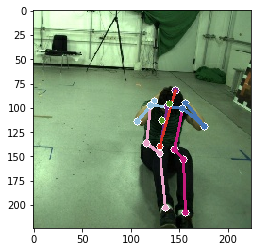

In [20]:
%matplotlib inline
image = original[0].numpy()
kp2d = original[1].numpy()[:, :2]
vis = original[1].numpy()[:, 2]

image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show image with predicted 2d keypoints

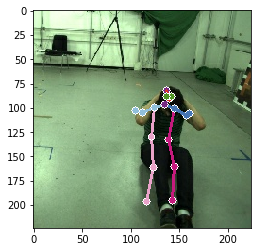

In [21]:
image = original[0].numpy()
kp2d = np.squeeze(result['kp2d'].numpy())
vis = original[1].numpy()[:, 2]
image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show both poses in seperate plots 

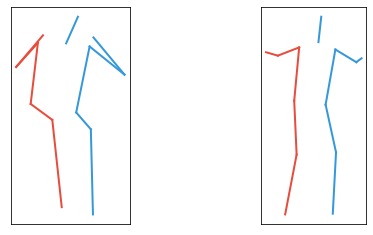

In [22]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

vis = np.expand_dims(original[1].numpy()[:, 2], -1)

kp2d_real = original[1].numpy() * vis
show_2d_pose(kp2d_real, vis, ax1)

kp2d_pred = result['kp2d'].numpy() * vis
show_2d_pose(kp2d_pred, vis, ax2)

<IPython.core.display.Javascript object>


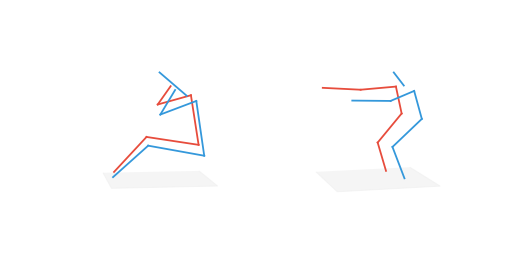

In [28]:
%matplotlib notebook
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# only use predicted camera
camera = np.squeeze(result['cam'].numpy())

# Plot 3d gt
kp3d_real = original[2].numpy()
#kp3d_real = rotate(kp3d_real, camera)
show_3d_pose(kp3d_real, ax1)

# Plot 3d predictions
kp3d_pred = np.squeeze(result['kp3d'].numpy())
kp3d_pred = kp3d_pred[:config.NUM_KP3D, :] # only lsp prediction
#kp3d_pred = rotate(kp3d_pred, camera)
show_3d_pose(kp3d_pred, ax2)

In [26]:
image = original[0].numpy()

vertices = np.squeeze(result['vertices'].numpy())

In [27]:
from trimesh_renderer import TrimeshRenderer
renderer = TrimeshRenderer()

mesh = renderer.mesh(vertices)
mesh.show()

/home/mmc-user/.virtualenvs/hmr2-notebook/lib/python3.6/site-packages/trimesh/scene/scene.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.graph.nodes:
